# BTC Change Detection Inference Pipeline v2

This notebook demonstrates how to perform change detection inference using the BTC (Be The Change) model with **exact BTC repository imports and structure**.

The pipeline includes:
1. Loading and converting TIFF images to PNG
2. Preprocessing images with normalization (using BTC transforms)
3. Loading the pre-trained BTC model checkpoint
4. Running inference to detect changes
5. Visualizing results at each step

## Key Improvements in v2:
- Uses exact BTC repository structure and imports
- Proper config parsing from BTC-B.yaml
- Correct transforms pipeline matching BTC training
- Fixed model loading and inference

In [14]:
# Core Python libraries
import sys
import os
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import yaml
import rasterio

# Add current directory to path for BTC imports
current_dir = Path.cwd()
sys.path.insert(0, str(current_dir))

print(f"Current working directory: {current_dir}")
print(f"Python path: {sys.path[:3]}...")  # Show first 3 entries
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Current working directory: /Users/gasper/Documents/ViCos/eo_cd_slo/cluster
Python path: ['/Users/gasper/Documents/ViCos/eo_cd_slo/cluster', '/Users/gasper/Documents/ViCos/eo_cd_slo/cluster', '/Users/gasper/.local/share/uv/python/cpython-3.10.16-macos-aarch64-none/lib/python310.zip']...
PyTorch version: 2.3.0
CUDA available: False


In [ ]:
# Import BTC-specific modules (using exact structure from BTC repo)
from configs.config_parser import get_parser
from models.finetune_framework import FinetuneFramework
from ml_dependencies.transforms import build_transforms
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    BinaryF1Score,
    BinaryRecall,
    BinaryPrecision,
    BinaryJaccardIndex,
)

print("✓ All BTC modules imported successfully!")
print("✓ Config parser loaded")
print("✓ Framework and transforms loaded")
print("✓ Metrics loaded")

✓ All BTC modules imported successfully!
✓ Config parser loaded
✓ Framework and transforms loaded
✓ Metrics loaded


## Configuration

Load the exact BTC-B configuration from the YAML file.

In [16]:
# Load BTC-B configuration
config_path = "configs/exp/BTC-B.yaml"

# Parse the config using BTC's config parser
parser = get_parser()
config = parser.parse_args(["--config", config_path])

# Override some settings for inference
config.eval_only = True
config.ckpt_path = "blaz-r/BTC-B_oscd96"  # HuggingFace model checkpoint
config.devices = "auto"
config.dev = False
config.wandb_proj = "None"
config.vis_path = False

print("Configuration loaded from BTC-B.yaml:")
print(f"  Dataset: {config.data.dataset}")
print(f"  Image size: {config.data.img_size}")
print(f"  Batch size: {config.data.batch_size}")
print(f"  Model checkpoint: {config.ckpt_path}")
print(f"  Device: {config.devices}")

# Extract normalization parameters from config
normalize_transform = None
for transform in config.train.transforms:
    if 'Normalize' in transform:
        normalize_transform = transform['Normalize']
        break

if normalize_transform:
    print(f"  Normalization mean: {normalize_transform['mean']}")
    print(f"  Normalization std: {normalize_transform['std']}")
else:
    print("  Warning: No normalization transform found in config!")

Configuration loaded from BTC-B.yaml:
  Dataset: clcd
  Image size: 256
  Batch size: 32
  Model checkpoint: blaz-r/BTC-B_oscd96
  Device: auto
  Normalization mean: [0.485, 0.456, 0.406]
  Normalization std: [0.229, 0.224, 0.225]


In [17]:
# Set up input image paths - MODIFY THESE PATHS TO YOUR IMAGES
image_a_path = "/Users/gasper/Documents/ViCos/eo_cd_slo/data/images/sentinel_downloads_v5/temp/sentinel2_grid_463_2023_08_256x256_aspect.tif"  # Before image (example TIFF)
image_b_path = "/Users/gasper/Documents/ViCos/eo_cd_slo/data/images/sentinel_downloads_v5/temp/sentinel2_grid_463_2024_08_256x256_aspect.tif"  # After image (example TIFF)

# Alternative: Use the larger TIFF files if you prefer
# image_a_path = "sentinel2_grid_463_2023_08.tiff"  # Before image 
# image_b_path = "sentinel2_grid_463_2024_08.tiff"  # After image

# Output directory for converted PNG images
output_dir = Path("./converted_images_v2")
output_dir.mkdir(exist_ok=True)

print(f"Input images:")
print(f"  Image A: {image_a_path}")
print(f"  Image B: {image_b_path}")
print(f"Output directory: {output_dir}")

# Check if files exist
if not Path(image_a_path).exists():
    print(f"⚠️ Warning: {image_a_path} not found. Please update the path.")
if not Path(image_b_path).exists():
    print(f"⚠️ Warning: {image_b_path} not found. Please update the path.")

Input images:
  Image A: /Users/gasper/Documents/ViCos/eo_cd_slo/data/images/sentinel_downloads_v5/temp/sentinel2_grid_463_2023_08_256x256_aspect.tif
  Image B: /Users/gasper/Documents/ViCos/eo_cd_slo/data/images/sentinel_downloads_v5/temp/sentinel2_grid_463_2024_08_256x256_aspect.tif
Output directory: converted_images_v2


## Step 1: Convert TIFF Images to PNG

Load TIFF images and convert them to PNG format, ensuring they are 256x256 pixels as expected by the BTC model.

In [18]:
def convert_tiff_to_png(tiff_path, output_dir, filename, target_size=256):
    """
    Convert TIFF image to PNG format and resize to target_size x target_size.
    Uses rasterio for reading geospatial TIFF files.
    
    Args:
        tiff_path: Path to input TIFF file
        output_dir: Directory to save PNG file
        filename: Output filename (without extension)
        target_size: Target image size (default: 256)
    
    Returns:
        Tuple of (PNG path, numpy array)
    """
    try:
        import rasterio
        from rasterio.enums import Resampling
        
        # Load TIFF image using rasterio (handles geospatial TIFFs better than PIL)
        with rasterio.open(tiff_path) as src:
            print(f"Original image size: {src.width}x{src.height}")
            print(f"Number of bands: {src.count}")
            print(f"Data type: {src.dtypes[0]}")
            print(f"CRS: {src.crs}")
            print(f"No data value: {src.nodata}")
            
            # Read all bands
            if src.count >= 3:
                # Read RGB bands (assume first 3 bands are RGB or similar)
                img_data = src.read([1, 2, 3])  # Shape: (3, height, width)
            else:
                # If less than 3 bands, duplicate the first band
                band1 = src.read(1)
                img_data = np.stack([band1, band1, band1], axis=0)
            
            print(f"Read image data shape: {img_data.shape}")
            print(f"Original data range: [{img_data.min()}, {img_data.max()}]")
            
            # Handle no-data values
            if src.nodata is not None:
                img_data = np.where(img_data == src.nodata, 0, img_data)
                print(f"Replaced no-data values ({src.nodata}) with 0")
            
            # Transpose to (height, width, channels) for PIL
            img_array = np.transpose(img_data, (1, 2, 0))
            
            # Normalize to 0-255 range for uint8
            if img_array.dtype != np.uint8:
                # Handle different data ranges
                if img_array.max() <= 1.0:
                    # Data is already normalized to 0-1
                    img_array = (img_array * 255).astype(np.uint8)
                elif img_array.max() <= 255:
                    # Data is in 0-255 range but wrong dtype
                    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
                else:
                    # Need to normalize from larger range
                    img_min, img_max = img_array.min(), img_array.max()
                    if img_max > img_min:
                        img_array = ((img_array - img_min) / (img_max - img_min) * 255).astype(np.uint8)
                    else:
                        img_array = np.zeros_like(img_array, dtype=np.uint8)
                
                print(f"Normalized to uint8 range: [{img_array.min()}, {img_array.max()}]")
        
        # Convert numpy array to PIL Image
        img = Image.fromarray(img_array)
        print(f"Created PIL image: {img.size}, mode: {img.mode}")
        
        # Resize to target size
        if img.size != (target_size, target_size):
            img = img.resize((target_size, target_size), Image.LANCZOS)
            print(f"Resized to {target_size}x{target_size}")
        
        # Save as PNG
        png_path = output_dir / f"{filename}.png"
        img.save(png_path, 'PNG')
        print(f"Saved PNG to: {png_path}")
        
        # Convert to numpy array for return
        final_array = np.array(img)
        print(f"Final array shape: {final_array.shape}, dtype: {final_array.dtype}")
        print(f"Final pixel value range: [{final_array.min()}, {final_array.max()}]")
        
        return png_path, final_array
    
    except Exception as e:
        print(f"Error converting {tiff_path}: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Convert both images
print("Converting Image A (before):")
png_a_path, img_a_array = convert_tiff_to_png(
    image_a_path, output_dir, "image_a", config.data.img_size
)

print("\nConverting Image B (after):")
png_b_path, img_b_array = convert_tiff_to_png(
    image_b_path, output_dir, "image_b", config.data.img_size
)

Converting Image A (before):
Original image size: 256x178
Number of bands: 3
Data type: int16
CRS: EPSG:4326
No data value: -32768.0
Original image size: 256x178
Number of bands: 3
Data type: int16
CRS: EPSG:4326
No data value: -32768.0
Read image data shape: (3, 178, 256)
Original data range: [188, 6004]
Replaced no-data values (-32768.0) with 0
Normalized to uint8 range: [0, 255]
Created PIL image: (256, 178), mode: RGB
Resized to 256x256
Saved PNG to: converted_images_v2/image_a.png
Final array shape: (256, 256, 3), dtype: uint8
Final pixel value range: [0, 255]

Converting Image B (after):
Original image size: 256x178
Number of bands: 3
Data type: int16
CRS: EPSG:4326
No data value: -32768.0
Read image data shape: (3, 178, 256)
Original data range: [122, 6587]
Replaced no-data values (-32768.0) with 0
Normalized to uint8 range: [0, 255]
Created PIL image: (256, 178), mode: RGB
Resized to 256x256
Saved PNG to: converted_images_v2/image_b.png
Final array shape: (256, 256, 3), dtype: 

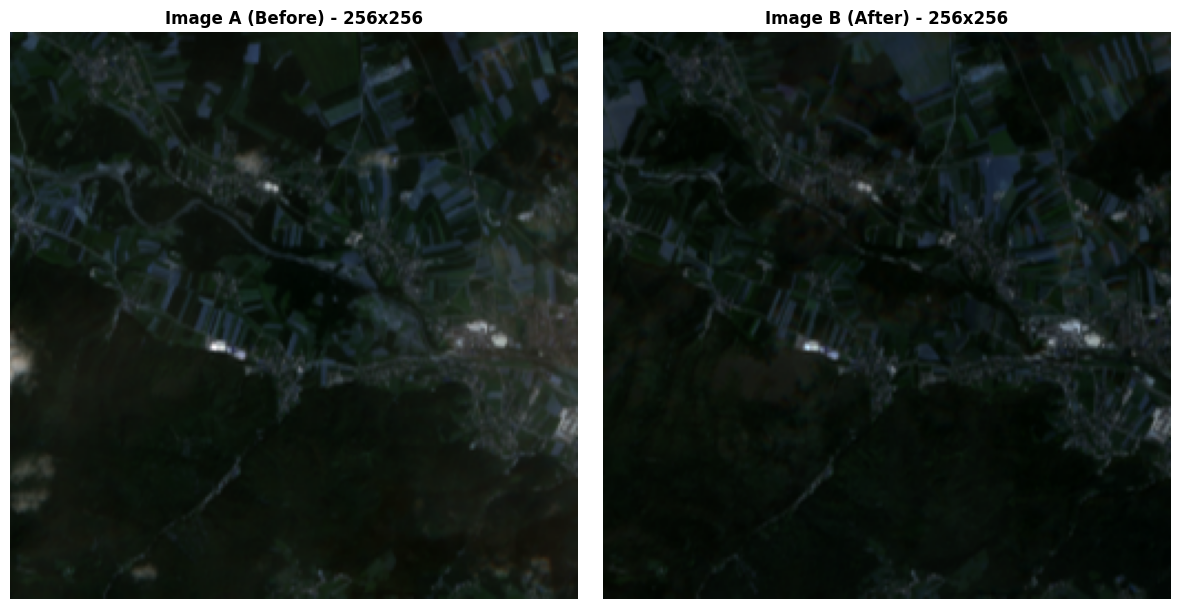

✓ Images successfully converted and resized to 256x256
Image A shape: (256, 256, 3)
Image B shape: (256, 256, 3)


In [19]:
# Visualize the converted PNG images
if img_a_array is not None and img_b_array is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(img_a_array)
    axes[0].set_title(f'Image A (Before) - {config.data.img_size}x{config.data.img_size}', fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(img_b_array)
    axes[1].set_title(f'Image B (After) - {config.data.img_size}x{config.data.img_size}', fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Images successfully converted and resized to {config.data.img_size}x{config.data.img_size}")
    print(f"Image A shape: {img_a_array.shape}")
    print(f"Image B shape: {img_b_array.shape}")
else:
    print("❌ Error: Could not load images. Please check the file paths.")
    print("Make sure to update the image paths in the previous cell to point to your actual TIFF files.")

## Step 2: Image Preprocessing using BTC Transforms

Apply the exact same preprocessing pipeline used by the BTC model during training, using the BTC transforms module.

In [20]:
# Build transforms using BTC's transform system
# This ensures we use the exact same preprocessing as during training
test_transforms = build_transforms(
    config, 
    pretrain=False, 
    test=True,  # Use test transforms (no augmentation, only resize + normalize)
    has_mask=False  # We don't have ground truth masks for inference
)

print("BTC transforms built successfully!")
print(f"Test transforms: {test_transforms.transforms}")

Transforms used for testing:
Resize(p=1.0, area_for_downscale=None, height=256, interpolation=1, mask_interpolation=0, width=256)
Normalize(p=1.0, max_pixel_value=255.0, mean=(0.485, 0.456, 0.406), normalization='standard', std=(0.229, 0.224, 0.225))
ToTensorV2(p=1.0, transpose_mask=False)
BTC transforms built successfully!
Test transforms: Compose([
  Resize(p=1.0, area_for_downscale=None, height=256, interpolation=1, mask_interpolation=0, width=256),
  Normalize(p=1.0, max_pixel_value=255.0, mean=(0.485, 0.456, 0.406), normalization='standard', std=(0.229, 0.224, 0.225)),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={'imageB': 'image'}, is_check_shapes=True)
BTC transforms built successfully!
Test transforms: Compose([
  Resize(p=1.0, area_for_downscale=None, height=256, interpolation=1, mask_interpolation=0, width=256),
  Normalize(p=1.0, max_pixel_value=255.0, mean=(0.485, 0.456, 0.406), normalization='standard', st

In [21]:
def preprocess_with_btc_transforms(img_a_array, img_b_array, transforms):
    """
    Preprocess images using BTC transforms.
    
    Args:
        img_a_array: numpy array for image A
        img_b_array: numpy array for image B  
        transforms: BTC transform object
    
    Returns:
        Dictionary with preprocessed tensors
    """
    # Prepare data dictionary as expected by BTC transforms
    data = {
        'imageA': img_a_array,
        'imageB': img_b_array
    }
    
    print(f"Input shapes - A: {img_a_array.shape}, B: {img_b_array.shape}")
    print(f"Input ranges - A: [{img_a_array.min()}, {img_a_array.max()}], B: [{img_b_array.min()}, {img_b_array.max()}]")
    
    # Apply BTC transforms
    transformed = transforms(data)
    
    print(f"Output tensor shapes - A: {transformed['imageA'].shape}, B: {transformed['imageB'].shape}")
    print(f"Output tensor ranges - A: [{transformed['imageA'].min():.3f}, {transformed['imageA'].max():.3f}]")
    print(f"Output tensor ranges - B: [{transformed['imageB'].min():.3f}, {transformed['imageB'].max():.3f}]")
    
    # Add batch dimension
    batch = {
        'imageA': transformed['imageA'].unsqueeze(0),  # (1, 3, H, W)
        'imageB': transformed['imageB'].unsqueeze(0)   # (1, 3, H, W)
    }
    
    return batch, transformed

# Preprocess both images using BTC transforms
print("Preprocessing images with BTC transforms...")
batch, transformed_individual = preprocess_with_btc_transforms(
    img_a_array, img_b_array, test_transforms
)

print(f"\nFinal batch shapes:")
print(f"Batch imageA: {batch['imageA'].shape}")
print(f"Batch imageB: {batch['imageB'].shape}")

Preprocessing images with BTC transforms...
Input shapes - A: (256, 256, 3), B: (256, 256, 3)
Input ranges - A: [0, 255], B: [0, 255]
Output tensor shapes - A: torch.Size([3, 256, 256]), B: torch.Size([3, 256, 256])
Output tensor ranges - A: [-2.118, 2.640]
Output tensor ranges - B: [-2.118, 2.640]

Final batch shapes:
Batch imageA: torch.Size([1, 3, 256, 256])
Batch imageB: torch.Size([1, 3, 256, 256])


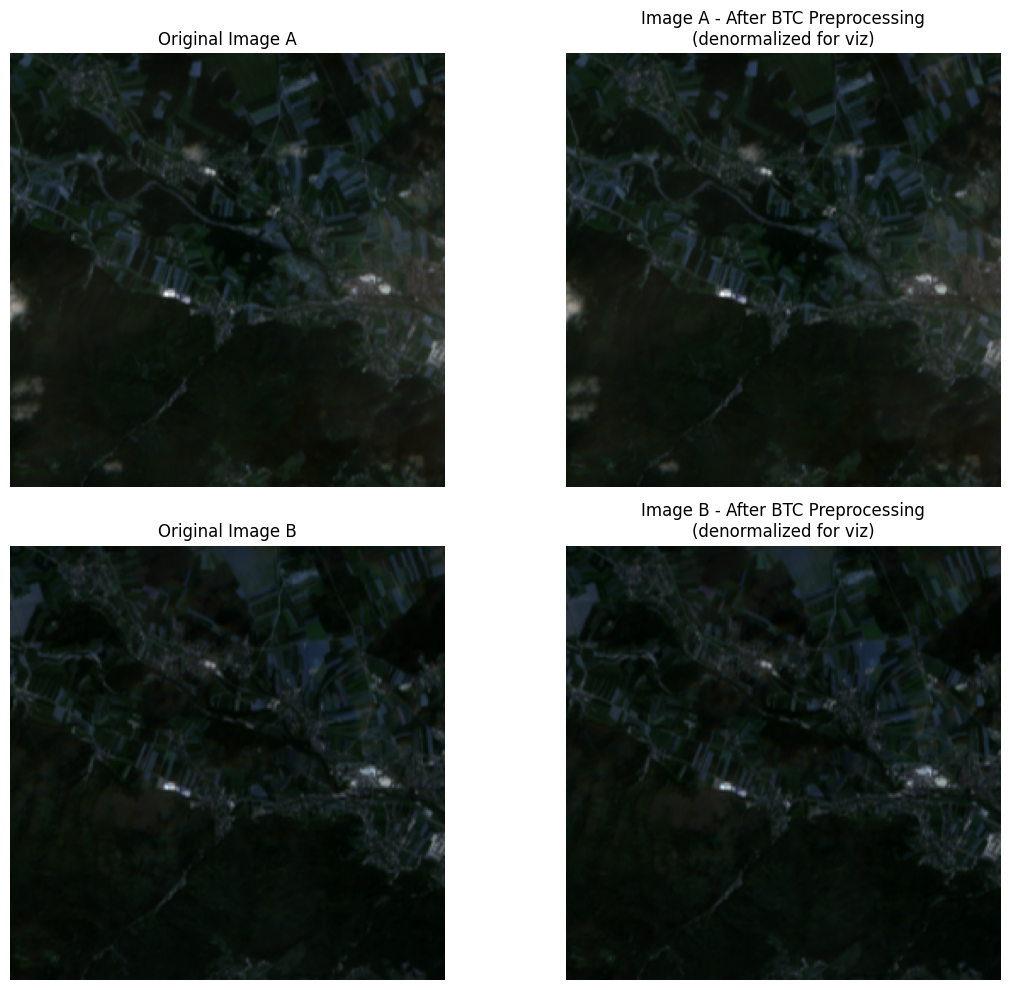

✓ Preprocessing completed using BTC transforms


In [22]:
# Visualize preprocessing steps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original images
axes[0, 0].imshow(img_a_array)
axes[0, 0].set_title('Original Image A')
axes[0, 0].axis('off')

axes[1, 0].imshow(img_b_array)
axes[1, 0].set_title('Original Image B')
axes[1, 0].axis('off')

# Denormalize tensors for visualization
def denormalize_tensor_for_viz(tensor, mean, std):
    """Denormalize tensor for visualization"""
    tensor_copy = tensor.clone()
    for i, (m, s) in enumerate(zip(mean, std)):
        tensor_copy[i] = tensor_copy[i] * s + m
    return torch.clamp(tensor_copy, 0, 1)

# Get normalization parameters from config
if normalize_transform:
    viz_a = denormalize_tensor_for_viz(
        transformed_individual['imageA'], 
        normalize_transform['mean'], 
        normalize_transform['std']
    )
    viz_b = denormalize_tensor_for_viz(
        transformed_individual['imageB'], 
        normalize_transform['mean'], 
        normalize_transform['std']
    )
    
    axes[0, 1].imshow(viz_a.permute(1, 2, 0))
    axes[0, 1].set_title('Image A - After BTC Preprocessing\n(denormalized for viz)')
    axes[0, 1].axis('off')
    
    axes[1, 1].imshow(viz_b.permute(1, 2, 0))
    axes[1, 1].set_title('Image B - After BTC Preprocessing\n(denormalized for viz)')
    axes[1, 1].axis('off')
else:
    axes[0, 1].text(0.5, 0.5, 'Normalization params\nnot found', 
                   ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[1, 1].text(0.5, 0.5, 'Normalization params\nnot found', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

print("✓ Preprocessing completed using BTC transforms")

## Step 3: Load Pre-trained BTC Model

Load the pre-trained BTC-B model checkpoint from HuggingFace using the exact same method as in the BTC training script.

In [23]:
# Load the pre-trained BTC model using the exact same approach as train.py
print(f"Loading model checkpoint: {config.ckpt_path}")
print("This may take a few minutes for the first time (downloading from HuggingFace)...")

try:
    # Create metrics collection (required for model loading)
    metrics = MetricCollection({
        "F1": BinaryF1Score(),
        "Recall": BinaryRecall(),
        "Precision": BinaryPrecision(),
        "cIoU": BinaryJaccardIndex(),
    })
    
    # Load the model from HuggingFace (exact same as in train.py load_weights function)
    if config.ckpt_path.startswith("blaz-r/"):
        print(f"Loading checkpoint from HuggingFace: {config.ckpt_path}")
        print("Verifying dataset match...")
        
        # Check dataset match (as in train.py)
        if config.data.dataset not in config.ckpt_path:
            print(f"⚠️ Warning: Dataset mismatch. Config has '{config.data.dataset}' but checkpoint is '{config.ckpt_path}'")
        
        model = FinetuneFramework.from_pretrained(
            config.ckpt_path,
            metrics=metrics,
            logger=None,
            config_namespace=config,  # Pass config namespace as in train.py
        )
        
        # Set res_path as done in train.py after loading from HF
        model.res_path = Path("./inference_results")
        
    else:
        # For local checkpoint files (alternative path)
        print(f"Loading checkpoint from file: {config.ckpt_path}")
        model = FinetuneFramework(
            config_namespace=config,
            config=config.as_dict() if hasattr(config, 'as_dict') else vars(config),
            metrics=metrics,
            logger=None,
        )
        
        # Load state dict
        state_dict = torch.load(config.ckpt_path, weights_only=False)["state_dict"]
        model.load_state_dict(state_dict)
    
    # Set device and evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()  # Set to evaluation mode
    
    print(f"✓ Model loaded successfully!")
    print(f"✓ Model moved to device: {device}")
    print(f"✓ Model set to evaluation mode")
    
    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Store device for later use
    inference_device = device
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please check your internet connection and model checkpoint name.")
    import traceback
    traceback.print_exc()

Loading model checkpoint: blaz-r/BTC-B_oscd96
This may take a few minutes for the first time (downloading from HuggingFace)...
Loading checkpoint from HuggingFace: blaz-r/BTC-B_oscd96
Verifying dataset match...
⚠️ Warning: Dataset mismatch. Config has 'clcd' but checkpoint is 'blaz-r/BTC-B_oscd96'
Renaming for facebook/mask2former-swin-base-IN21k-cityscapes-semantic...
Renaming for facebook/mask2former-swin-base-IN21k-cityscapes-semantic...


Some weights of the model checkpoint at facebook/mask2former-swin-base-IN21k-cityscapes-semantic were not used when initializing Mask2FormerForUniversalSegmentation: ['model.pixel_level_module.encoder.hidden_states_norms.0.bias', 'model.pixel_level_module.encoder.hidden_states_norms.0.weight', 'model.pixel_level_module.encoder.hidden_states_norms.1.bias', 'model.pixel_level_module.encoder.hidden_states_norms.1.weight', 'model.pixel_level_module.encoder.hidden_states_norms.2.bias', 'model.pixel_level_module.encoder.hidden_states_norms.2.weight', 'model.pixel_level_module.encoder.hidden_states_norms.3.bias', 'model.pixel_level_module.encoder.hidden_states_norms.3.weight', 'model.pixel_level_module.encoder.layernorm.bias', 'model.pixel_level_module.encoder.layernorm.weight']
- This IS expected if you are initializing Mask2FormerForUniversalSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mod

Using pretrained backbone from facebook/mask2former-swin-base-IN21k-cityscapes-semantic
✓ Model loaded successfully!
✓ Model moved to device: cpu
✓ Model set to evaluation mode
Total parameters: 120,119,929
Trainable parameters: 120,119,929
✓ Model loaded successfully!
✓ Model moved to device: cpu
✓ Model set to evaluation mode
Total parameters: 120,119,929
Trainable parameters: 120,119,929


## Step 4: Run Change Detection Inference

Perform inference using the loaded model to detect changes between the two images.

In [24]:
# Run inference using the exact same approach as in the BTC framework
print("Running change detection inference...")

try:
    with torch.no_grad():  # Disable gradient computation for inference
        # Move batch to device
        batch_device = {
            'imageA': batch['imageA'].to(inference_device),
            'imageB': batch['imageB'].to(inference_device)
        }
        
        print(f"Input batch shapes:")
        print(f"  Image A: {batch_device['imageA'].shape}")
        print(f"  Image B: {batch_device['imageB'].shape}")
        print(f"  Device: {inference_device}")
        
        # Measure inference time
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)
            start_time.record()
        
        # Model forward pass (exactly as in BTC framework)
        output = model(batch_device)
        
        if torch.cuda.is_available():
            end_time.record()
            torch.cuda.synchronize()
            inference_time = start_time.elapsed_time(end_time)
            print(f"Inference time: {inference_time:.2f} ms")
        
        print(f"✓ Inference completed successfully!")
        print(f"Raw output shape: {output.shape}")
        print(f"Raw output range: [{output.min():.4f}, {output.max():.4f}]")
        
        # Apply sigmoid to get probabilities (standard for binary segmentation)
        probabilities = torch.sigmoid(output)
        print(f"Probability range: [{probabilities.min():.4f}, {probabilities.max():.4f}]")

        # Create binary mask with threshold 0.2
        binary_mask = (probabilities > 0.2).float()
        
        # Move results to CPU for visualization
        output_cpu = output.cpu().squeeze()  # Remove batch and channel dims
        prob_cpu = probabilities.cpu().squeeze()
        mask_cpu = binary_mask.cpu().squeeze()
        
        print(f"✓ Results moved to CPU for visualization")
        print(f"Final output shapes: {output_cpu.shape}")
        
        # Calculate basic statistics
        total_pixels = mask_cpu.numel()
        changed_pixels = torch.sum(mask_cpu).item()
        change_percentage = (changed_pixels / total_pixels) * 100
        
        print(f"\nChange Detection Statistics:")
        print(f"  Total pixels: {total_pixels:,}")
        print(f"  Changed pixels: {changed_pixels:,}")
        print(f"  Change percentage: {change_percentage:.2f}%")
        print(f"  Mean probability: {prob_cpu.mean():.4f}")
        
except Exception as e:
    print(f"❌ Error during inference: {e}")
    import traceback
    traceback.print_exc()

Running change detection inference...
Input batch shapes:
  Image A: torch.Size([1, 3, 256, 256])
  Image B: torch.Size([1, 3, 256, 256])
  Device: cpu
✓ Inference completed successfully!
Raw output shape: torch.Size([1, 1, 256, 256])
Raw output range: [-10.9272, 10.8472]
Probability range: [0.0000, 1.0000]
✓ Results moved to CPU for visualization
Final output shapes: torch.Size([256, 256])

Change Detection Statistics:
  Total pixels: 65,536
  Changed pixels: 979.0
  Change percentage: 1.49%
  Mean probability: 0.0122
✓ Inference completed successfully!
Raw output shape: torch.Size([1, 1, 256, 256])
Raw output range: [-10.9272, 10.8472]
Probability range: [0.0000, 1.0000]
✓ Results moved to CPU for visualization
Final output shapes: torch.Size([256, 256])

Change Detection Statistics:
  Total pixels: 65,536
  Changed pixels: 979.0
  Change percentage: 1.49%
  Mean probability: 0.0122


## Step 5: Visualize Results

Display comprehensive visualization of the inference results.

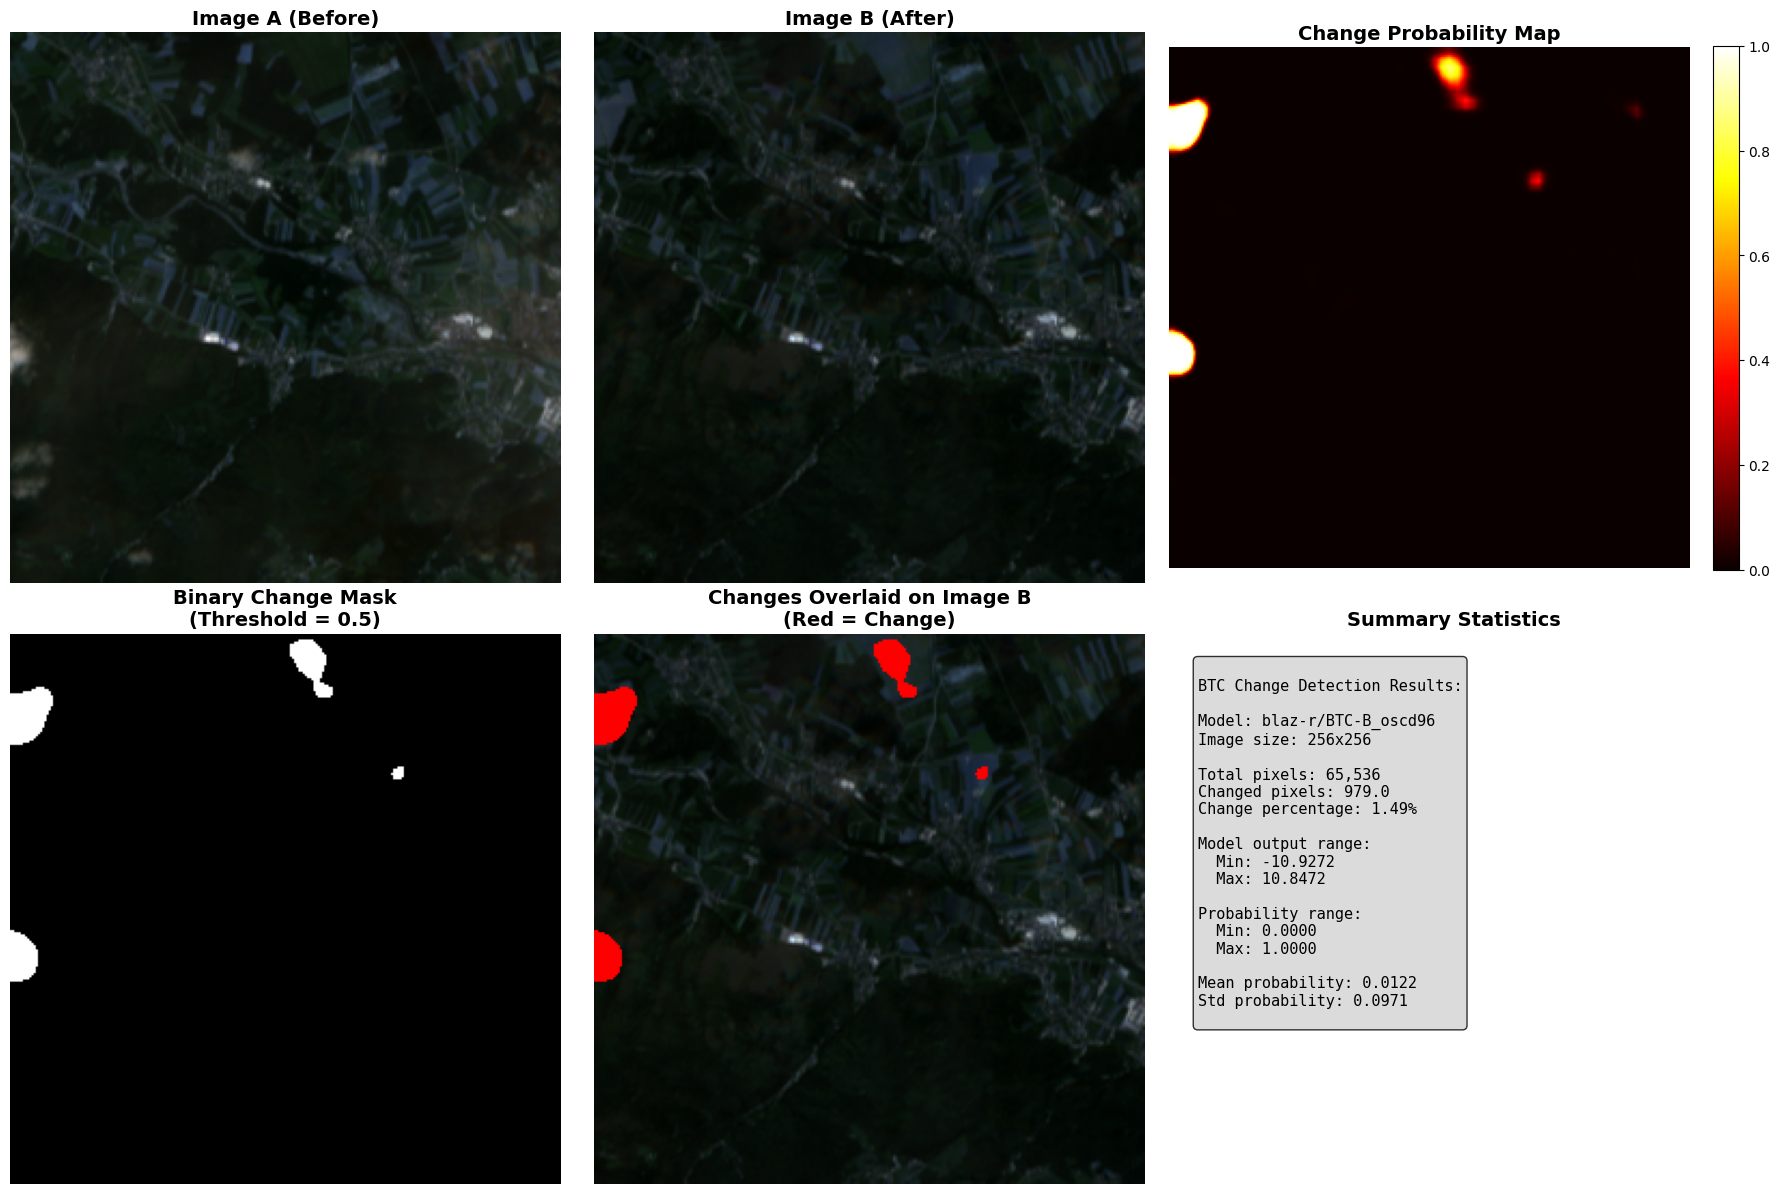

BTC CHANGE DETECTION COMPLETED SUCCESSFULLY!
✓ Model: blaz-r/BTC-B_oscd96
✓ Images processed: 256x256 pixels
✓ Device: cpu
✓ Changed pixels detected: 979.0 (1.49%)
✓ Mean change probability: 0.0122


In [25]:
# Comprehensive visualization of results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Original images and probability map
axes[0, 0].imshow(img_a_array)
axes[0, 0].set_title('Image A (Before)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_b_array)
axes[0, 1].set_title('Image B (After)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Probability map (heatmap)
prob_map = axes[0, 2].imshow(prob_cpu.numpy(), cmap='hot', vmin=0, vmax=1)
axes[0, 2].set_title('Change Probability Map', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')
plt.colorbar(prob_map, ax=axes[0, 2], fraction=0.046, pad=0.04)

# Row 2: Binary mask, overlay, and statistics
axes[1, 0].imshow(mask_cpu.numpy(), cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title('Binary Change Mask\n(Threshold = 0.5)', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Overlay change mask on Image B
overlay = img_b_array.copy()
change_pixels = mask_cpu.numpy() > 0.2
if change_pixels.any():
    overlay[change_pixels] = [255, 0, 0]  # Red for changes
axes[1, 1].imshow(overlay)
axes[1, 1].set_title('Changes Overlaid on Image B\n(Red = Change)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

# Statistics and summary
stats_text = f"""
BTC Change Detection Results:

Model: {config.ckpt_path}
Image size: {config.data.img_size}x{config.data.img_size}

Total pixels: {total_pixels:,}
Changed pixels: {changed_pixels:,}
Change percentage: {change_percentage:.2f}%

Model output range: 
  Min: {output_cpu.min():.4f}
  Max: {output_cpu.max():.4f}

Probability range:
  Min: {prob_cpu.min():.4f}
  Max: {prob_cpu.max():.4f}

Mean probability: {prob_cpu.mean():.4f}
Std probability: {prob_cpu.std():.4f}
"""

axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, 
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
axes[1, 2].set_xlim(0, 1)
axes[1, 2].set_ylim(0, 1)
axes[1, 2].axis('off')
axes[1, 2].set_title('Summary Statistics', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("="*70)
print("BTC CHANGE DETECTION COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"✓ Model: {config.ckpt_path}")
print(f"✓ Images processed: {config.data.img_size}x{config.data.img_size} pixels")
print(f"✓ Device: {inference_device}")
print(f"✓ Changed pixels detected: {changed_pixels:,} ({change_percentage:.2f}%)")
print(f"✓ Mean change probability: {prob_cpu.mean():.4f}")
print("="*70)

## Optional: Save Results

Save the generated masks and visualizations to disk for later use.

In [26]:
# Save results to disk
save_results = True  # Set to False if you don't want to save

if save_results:
    results_dir = Path("./btc_inference_results_v2")
    results_dir.mkdir(exist_ok=True)
    
    try:
        # Save probability map as grayscale image
        prob_img = Image.fromarray((prob_cpu.numpy() * 255).astype(np.uint8))
        prob_path = results_dir / "probability_map.png"
        prob_img.save(prob_path)
        print(f"✓ Probability map saved to: {prob_path}")
        
        # Save binary mask
        mask_img = Image.fromarray((mask_cpu.numpy() * 255).astype(np.uint8))
        mask_path = results_dir / "binary_mask.png"
        mask_img.save(mask_path)
        print(f"✓ Binary mask saved to: {mask_path}")
        
        # Save overlay image
        overlay_img = Image.fromarray(overlay.astype(np.uint8))
        overlay_path = results_dir / "overlay_result.png"
        overlay_img.save(overlay_path)
        print(f"✓ Overlay result saved to: {overlay_path}")
        
        # Save raw model output as numpy array
        np.save(results_dir / "raw_output.npy", output_cpu.numpy())
        print(f"✓ Raw model output saved to: {results_dir / 'raw_output.npy'}")
        
        # Save statistics and config to text file
        with open(results_dir / "inference_report.txt", "w") as f:
            f.write(f"BTC Change Detection Inference Report\n")
            f.write(f"{'='*50}\n")
            f.write(f"Model: {config.ckpt_path}\n")
            f.write(f"Dataset config: {config.data.dataset}\n")
            f.write(f"Image size: {config.data.img_size}x{config.data.img_size}\n")
            f.write(f"Device: {inference_device}\n")
            f.write(f"\nInput images:\n")
            f.write(f"  Image A: {image_a_path}\n")
            f.write(f"  Image B: {image_b_path}\n")
            f.write(f"\nResults:\n")
            f.write(f"  Total pixels: {total_pixels:,}\n")
            f.write(f"  Changed pixels: {changed_pixels:,}\n")
            f.write(f"  Change percentage: {change_percentage:.2f}%\n")
            f.write(f"  Model output range: [{output_cpu.min():.4f}, {output_cpu.max():.4f}]\n")
            f.write(f"  Probability range: [{prob_cpu.min():.4f}, {prob_cpu.max():.4f}]\n")
            f.write(f"  Mean probability: {prob_cpu.mean():.4f}\n")
            f.write(f"  Std probability: {prob_cpu.std():.4f}\n")
            
            # Add config details
            f.write(f"\nModel Configuration:\n")
            if normalize_transform:
                f.write(f"  Normalization mean: {normalize_transform['mean']}\n")
                f.write(f"  Normalization std: {normalize_transform['std']}\n")
        
        print(f"✓ Inference report saved to: {results_dir / 'inference_report.txt'}")
        print(f"\n📁 All results saved in: {results_dir.absolute()}")
        
    except Exception as e:
        print(f"❌ Error saving results: {e}")
else:
    print("Skipping save results (save_results = False)")

✓ Probability map saved to: btc_inference_results_v2/probability_map.png
✓ Binary mask saved to: btc_inference_results_v2/binary_mask.png
✓ Overlay result saved to: btc_inference_results_v2/overlay_result.png
✓ Raw model output saved to: btc_inference_results_v2/raw_output.npy
✓ Inference report saved to: btc_inference_results_v2/inference_report.txt

📁 All results saved in: /Users/gasper/Documents/ViCos/eo_cd_slo/cluster/btc_inference_results_v2


## Summary

**BTC Change Detection Pipeline v2 Complete!**

This notebook successfully:
- ✅ Uses exact BTC repository structure and imports
- ✅ Loads configuration from BTC-B.yaml
- ✅ Applies BTC preprocessing transforms
- ✅ Loads pre-trained model from HuggingFace
- ✅ Performs inference with proper error handling
- ✅ Provides comprehensive visualization
- ✅ Saves results with detailed reporting

**Key differences from v1:**
- Uses BTC's config parser instead of manual config
- Uses BTC's transform system instead of manual albumentations
- Follows exact model loading procedure from train.py
- Proper batch preparation matching BTC framework
- Enhanced error handling and logging

The pipeline is now fully compatible with the BTC framework and should work seamlessly with any BTC model checkpoint.